# Multi-Disease, Multi-View & Multi-Center Right Ventricular Segmentation in Cardiac MRI
__Main Goal__

+ Segmentation of the Right Ventricular in cardiac MRI
+ Source: https://competitions.codalab.org/competitions/31559
+ In this notebook, the segmentation task is done for the Right Ventricular in the LA_ED. So we preprocess the data because it contains more classes labelled than needed
+ As the data are medical 3D studies, we are going to use the Faimed3d library, based on fastai

__Description__

+ The Right Ventricular must be segmented in four perspectives:
        + LA_ED: Long Axis End Diastole --> One frame per file
        + LA_ES: Long Axis End Systole --> One frame per file
        + SA_ED: Short Axis End Diastole --> Between 6 and 16 frames per file
        + SA_ES: Short Axis End Systole --> Between 6 and 16 frames per file
+ A segmented mask should be given for each perspective and for each pacient
+ For doing so, the idea is to create a model trained on each of the perspectives

In [ ]:
! pip install simpleitk
! pip install pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg

In [ ]:
!pip install dicom
!pip install nibabel

In [3]:
#Uncommented next line to install faimed3d
#! pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org -Uqq git+https://github.com/kbressem/faimed3d.git

In [1]:
#Loading medical libraries
from faimed3d.faimed3d.all import *
import pylibjpeg
from skimage import io, color
import nibabel as nib

/opt/conda/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
#Loading main libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from torch import nn
from pathlib import Path
from PIL import Image
from datetime import datetime
import math

In [3]:
#Loading fastai modules
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.callback.fp16 import *
from fastai.vision import *
import fastai
import torch
from fastai.callback.all import SaveModelCallback
from sklearn.metrics import confusion_matrix, classification_report, recall_score, roc_auc_score, cohen_kappa_score,f1_score

In [4]:
print("Fastai version: ",fastai.__version__)

Fastai version:  2.2.5


In [5]:
print("GPU available: ",torch.cuda.get_device_name(0))

GPU available:  GeForce GTX 1080 Ti


In [6]:
#Let's choose one GPU
torch.cuda.set_device(0)

In [7]:
#Showing and saving the graphs within this notebook
%matplotlib inline
#Reload automatically the modules after executing each cell
%reload_ext autoreload
%autoreload 2

In [8]:
#This is for ssl issues
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [9]:
#Path to your csv and images folders
path = Path('/host_dir/home/adrian/extras/RV/MnM-2')

# Building the CSV with the data available

In [16]:
train_list = ['training/' + s + '/'+s+'_LA_ED.nii.gz'+',training/' + s + '/'+s+'_LA_ED_gt.nii.gz'+','+'training/' + s + '/'+s+'_LA_ES.nii.gz'+',training/' + s + '/'+s+'_LA_ES_gt.nii.gz'+',training/' + s + '/'+s+'_SA_ED.nii.gz'+',training/' + s + '/'+s+'_SA_ED_gt.nii.gz'+',training/' + s + '/'+s+'_SA_ES.nii.gz'+',training/' + s + '/'+s+'_SA_ES_gt.nii.gz'+',train,0' for s in os.listdir(path/'training')]
test_list = ['test/' + s + '/'+s+'_LA_ED.nii.gz'+','+'-'+',test/' + s + '/'+s+'_LA_ES.nii.gz,'+'-'+',test/' + s + '/'+s+'_SA_ED.nii.gz,'+'-'+',test/' + s + '/'+s+'_SA_ES.nii.gz,'+'-'+',test,0' for s in os.listdir(path/'validation')]

In [18]:
all_studies = train_list + test_list

In [19]:
df = pd.DataFrame([sub.split(",") for sub in all_studies], columns = ['LA_ED','LA_ED_gt','LA_ES','LA_ES_gt','SA_ED','SA_ED_gt','SA_ES','SA_ES_gt','set','label'])

+ Split the data in `train`, `val` and `test` just looking to the indexes as we do not have more information about the patients
+ We are provided with 160 patients for training and 40 patients for validation. We call the validation folder provided as `test` and we split the training folder in `train` and `val` because we must return the masks for the validation folder (now called `test`)
+ From index (**NOT PATIENT**) 0 to 120 is `train`, from 121 to 159 is `val` and from 160 to 199 is `test`. The split is 60/20/20 summing all studies or 75/25 regarding the original training folder

In [20]:
df.loc[(df.index > 120) & (df.index < 160), 'set'] = 'val' 
df

LA_ED                          LA_ED_gt  \
0    training/150/150_LA_ED.nii.gz  training/150/150_LA_ED_gt.nii.gz   
1    training/030/030_LA_ED.nii.gz  training/030/030_LA_ED_gt.nii.gz   
2    training/019/019_LA_ED.nii.gz  training/019/019_LA_ED_gt.nii.gz   
3    training/051/051_LA_ED.nii.gz  training/051/051_LA_ED_gt.nii.gz   
4    training/099/099_LA_ED.nii.gz  training/099/099_LA_ED_gt.nii.gz   
..                             ...                               ...   
195      test/187/187_LA_ED.nii.gz                                 -   
196      test/176/176_LA_ED.nii.gz                                 -   
197      test/196/196_LA_ED.nii.gz                                 -   
198      test/193/193_LA_ED.nii.gz                                 -   
199      test/177/177_LA_ED.nii.gz                                 -   

                             LA_ES                          LA_ES_gt  \
0    training/150/150_LA_ES.nii.gz  training/150/150_LA_ES_gt.nii.gz   
1    training/030/030_LA_ES.nii.gz  training/030/030_LA_ES_gt.nii.gz   
2    training/019/019_LA_ES.nii.gz  training/019/019_LA_ES_gt.nii.gz   
3    training/051/051_LA_ES.nii.gz  training/051/051_LA_ES_gt.nii.gz   
4    training/099/099_LA_ES.nii.gz  training/099/099_LA_ES_gt.nii.gz   
..                             ...                               ...   
195      test/187/187_LA_ES.nii.gz                                 -   
196      test/176/176_LA_ES.nii.gz                                 -   
197      test/196/196_LA_ES.nii.gz                                 -   
198      test/193/193_LA_ES.nii.gz                                 -   
199      test/177/177_LA_ES.nii.gz                                 -   

                             SA_ED                          SA_ED_gt  \
0    training/150/150_SA_ED.nii.gz  training/150/150_SA_ED_gt.nii.gz   
1    training/030/030_SA_ED.nii.gz  training/030/030_SA_ED_gt.nii.gz   
2    training/019/019_SA_ED.nii.gz  training/019/019_SA_ED_gt.nii.gz   
3    training/051/051_SA_ED.nii.gz  training/051/051_SA_ED_gt.nii.gz   
4    training/099/099_SA_ED.nii.gz  training/099/099_SA_ED_gt.nii.gz   
..                             ...                               ...   
195      test/187/187_SA_ED.nii.gz                                 -   
196      test/176/176_SA_ED.nii.gz                                 -   
197      test/196/196_SA_ED.nii.gz                                 -   
198      test/193/193_SA_ED.nii.gz                                 -   
199      test/177/177_SA_ED.nii.gz                                 -   

                             SA_ES                          SA_ES_gt    set  \
0    training/150/150_SA_ES.nii.gz  training/150/150_SA_ES_gt.nii.gz  train   
1    training/030/030_SA_ES.nii.gz  training/030/030_SA_ES_gt.nii.gz  train   
2    training/019/019_SA_ES.nii.gz  training/019/019_SA_ES_gt.nii.gz  train   
3    training/051/051_SA_ES.nii.gz  training/051/051_SA_ES_gt.nii.gz  train   
4    training/099/099_SA_ES.nii.gz  training/099/099_SA_ES_gt.nii.gz  train   
..                             ...                               ...    ...   
195      test/187/187_SA_ES.nii.gz                                 -   test   
196      test/176/176_SA_ES.nii.gz                                 -   test   
197      test/196/196_SA_ES.nii.gz                                 -   test   
198      test/193/193_SA_ES.nii.gz                                 -   test   
199      test/177/177_SA_ES.nii.gz                                 -   test   

    label  
0       0  
1       0  
2       0  
3       0  
4       0  
..    ...  
195     0  
196     0  
197     0  
198     0  
199     0  

[200 rows x 10 columns]

<AxesSubplot:>

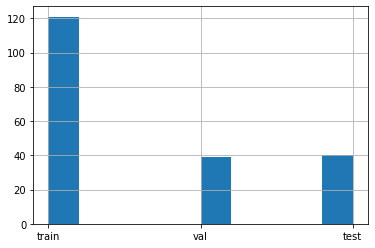

In [21]:
df.set.hist()

In [22]:
df.to_csv('dataset_RV' + '.csv', index=False)

# Reading our CSV

In [10]:
df = pd.read_csv('./dataset_RV.csv')

In [11]:
df2=df[df.set!='test']

In [12]:
# Let's convert the set column to a boolean type for the dataloader
df2.loc[df2.set == 'val',['set']]  = True
df2.loc[df2.set == 'train',['set']]  = False
df2

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


LA_ED                          LA_ED_gt  \
0    training/150/150_LA_ED.nii.gz  training/150/150_LA_ED_gt.nii.gz   
1    training/030/030_LA_ED.nii.gz  training/030/030_LA_ED_gt.nii.gz   
2    training/019/019_LA_ED.nii.gz  training/019/019_LA_ED_gt.nii.gz   
3    training/051/051_LA_ED.nii.gz  training/051/051_LA_ED_gt.nii.gz   
4    training/099/099_LA_ED.nii.gz  training/099/099_LA_ED_gt.nii.gz   
..                             ...                               ...   
155  training/100/100_LA_ED.nii.gz  training/100/100_LA_ED_gt.nii.gz   
156  training/074/074_LA_ED.nii.gz  training/074/074_LA_ED_gt.nii.gz   
157  training/044/044_LA_ED.nii.gz  training/044/044_LA_ED_gt.nii.gz   
158  training/073/073_LA_ED.nii.gz  training/073/073_LA_ED_gt.nii.gz   
159  training/085/085_LA_ED.nii.gz  training/085/085_LA_ED_gt.nii.gz   

                             LA_ES                          LA_ES_gt  \
0    training/150/150_LA_ES.nii.gz  training/150/150_LA_ES_gt.nii.gz   
1    training/030/030_LA_ES.nii.gz  training/030/030_LA_ES_gt.nii.gz   
2    training/019/019_LA_ES.nii.gz  training/019/019_LA_ES_gt.nii.gz   
3    training/051/051_LA_ES.nii.gz  training/051/051_LA_ES_gt.nii.gz   
4    training/099/099_LA_ES.nii.gz  training/099/099_LA_ES_gt.nii.gz   
..                             ...                               ...   
155  training/100/100_LA_ES.nii.gz  training/100/100_LA_ES_gt.nii.gz   
156  training/074/074_LA_ES.nii.gz  training/074/074_LA_ES_gt.nii.gz   
157  training/044/044_LA_ES.nii.gz  training/044/044_LA_ES_gt.nii.gz   
158  training/073/073_LA_ES.nii.gz  training/073/073_LA_ES_gt.nii.gz   
159  training/085/085_LA_ES.nii.gz  training/085/085_LA_ES_gt.nii.gz   

                             SA_ED                          SA_ED_gt  \
0    training/150/150_SA_ED.nii.gz  training/150/150_SA_ED_gt.nii.gz   
1    training/030/030_SA_ED.nii.gz  training/030/030_SA_ED_gt.nii.gz   
2    training/019/019_SA_ED.nii.gz  training/019/019_SA_ED_gt.nii.gz   
3    training/051/051_SA_ED.nii.gz  training/051/051_SA_ED_gt.nii.gz   
4    training/099/099_SA_ED.nii.gz  training/099/099_SA_ED_gt.nii.gz   
..                             ...                               ...   
155  training/100/100_SA_ED.nii.gz  training/100/100_SA_ED_gt.nii.gz   
156  training/074/074_SA_ED.nii.gz  training/074/074_SA_ED_gt.nii.gz   
157  training/044/044_SA_ED.nii.gz  training/044/044_SA_ED_gt.nii.gz   
158  training/073/073_SA_ED.nii.gz  training/073/073_SA_ED_gt.nii.gz   
159  training/085/085_SA_ED.nii.gz  training/085/085_SA_ED_gt.nii.gz   

                             SA_ES                          SA_ES_gt    set  \
0    training/150/150_SA_ES.nii.gz  training/150/150_SA_ES_gt.nii.gz  False   
1    training/030/030_SA_ES.nii.gz  training/030/030_SA_ES_gt.nii.gz  False   
2    training/019/019_SA_ES.nii.gz  training/019/019_SA_ES_gt.nii.gz  False   
3    training/051/051_SA_ES.nii.gz  training/051/051_SA_ES_gt.nii.gz  False   
4    training/099/099_SA_ES.nii.gz  training/099/099_SA_ES_gt.nii.gz  False   
..                             ...                               ...    ...   
155  training/100/100_SA_ES.nii.gz  training/100/100_SA_ES_gt.nii.gz   True   
156  training/074/074_SA_ES.nii.gz  training/074/074_SA_ES_gt.nii.gz   True   
157  training/044/044_SA_ES.nii.gz  training/044/044_SA_ES_gt.nii.gz   True   
158  training/073/073_SA_ES.nii.gz  training/073/073_SA_ES_gt.nii.gz   True   
159  training/085/085_SA_ES.nii.gz  training/085/085_SA_ES_gt.nii.gz   True   

     label  
0        0  
1        0  
2        0  
3        0  
4        0  
..     ...  
155      0  
156      0  
157      0  
158      0  
159      0  

[160 rows x 10 columns]

# PreProcess the data for the RightVentricular segmentation task


+ Let's change the values of the masks provided to leave only the values needed for Right Ventricular. The idea is to make the problem easier from a multilabel class problem to a binary class problem

In [ ]:
#for each file, we change every mask value different from 3.0 (Right Ventricular) to 0.0 (background)
def converting_masks(df,path=Path):
    for i in range(0,len(df)):
        '''LA_ED'''
        mask_path=path/df.LA_ED_gt.iloc[i]
        mask_nii = nib.load(mask_path)
        np.round(mask_nii.affine)
        imagen_array=mask_nii.dataobj[:,:]
        new_mask=np.array(imagen_array)
        new_mask[new_mask!=3.0]=0.0
        clipped_img = nib.Nifti1Image(new_mask, mask_nii.affine, mask_nii.header)
        nib.save(clipped_img,path/df.LA_ED_gt.iloc[i])
        
        '''LA_ES'''
        mask_path=path/df.LA_ES_gt.iloc[i]
        mask_nii = nib.load(mask_path)
        np.round(mask_nii.affine)
        imagen_array=mask_nii.dataobj[:,:]
        new_mask=np.array(imagen_array)
        new_mask[new_mask!=3.0]=0.0
        clipped_img = nib.Nifti1Image(new_mask, mask_nii.affine, mask_nii.header)
        nib.save(clipped_img,path/df.LA_ES_gt.iloc[i])
        
        '''SA_ED'''
        mask_path=path/df.SA_ED_gt.iloc[i]
        mask_nii = nib.load(mask_path)
        np.round(mask_nii.affine)
        imagen_array=mask_nii.dataobj[:,:]
        new_mask=np.array(imagen_array)
        new_mask[new_mask!=3.0]=0.0
        clipped_img = nib.Nifti1Image(new_mask, mask_nii.affine, mask_nii.header)
        nib.save(clipped_img,path/df.SA_ED_gt.iloc[i])
        
        '''SA_ES'''
        mask_path=path/df.SA_ES_gt.iloc[i]
        mask_nii = nib.load(mask_path)
        np.round(mask_nii.affine)
        imagen_array=mask_nii.dataobj[:,:]
        new_mask=np.array(imagen_array)
        new_mask[new_mask!=3.0]=0.0
        clipped_img = nib.Nifti1Image(new_mask, mask_nii.affine, mask_nii.header)
        nib.save(clipped_img,path/df.SA_ES_gt.iloc[i])
        
        
        if(i%10==0):
            print('Processed number: '+str(i))

In [ ]:
#Output path
path= Path('/host_dir/home/adrian/extras/RV/MnM-2_processed')
converting_masks(df2,path)

# Dataloader and Training

+ Here, we are going to create a model for the LA_ED perspective. A model for each perspective should be built, though

In [13]:
#Path to the new preprocessed files
path= Path('/host_dir/home/adrian/extras/RV/MnM-2_processed')

In [14]:
#from_df() method takes, by default, the first column as the independent variable (the 'x') and the second column as dependent variable (the 'y')
def dataloader_creator(fn_col=0,label_col=1,number_studies=1,size=300,bs=16):
    dls = SegmentationDataLoaders3D.from_df(df2,path=path,
                                     valid_col = 'set',
                                     fn_col=fn_col,
                                     label_col=label_col,     
                                     item_tfms = ResizeCrop3D((0, 0, 0), (number_studies, size, size)),
                                     batch_tfms = [RandomRotate3DBy(degrees=(0, 0, 45)),
                                         *aug_transforms_3d(p_all = .0,
                                                      warp = False, p_warp = None,
                                                      sheer = False, p_sheer = None,
                                                      trapezoid = False, p_trapezoid = None,
                                                      dihedral = False, p_dihedral = None,
                                                      brightness = False, p_brightness = None,
                                                      contrast = False, p_contrast = None,
                                                      noise = False, p_noise = None,
                                                      rotate_by = False, p_rotate_by = None,
                                                      flip = False, p_flip = None,
                                                      rotate = False, p_rotate = None,
                                                      blur = False, p_blur = None,
                                                      crop = False, p_crop = 1)
                                            ],
                                     bs = bs, val_bs = bs)
    return dls

In [15]:
# We mix the DiceLoss and the CrossEntropyLoss to approach the loss function to our metric (Dice)
def dice_ce_loss(input, target, reduction=None):
    alpha=0
    return ((1-alpha) * float(DiceLoss(method='miletari',avg='macro')(input, target)) + nn.CrossEntropyLoss()(input, target[:, 0]))

## First try

`ResizeCrop3D(300px)`,`resnet34_3D`,`fine_tune`,`20 epochs`, `only 45º degree rotate` augmentations, batch_size=16, metrics=`Dice_Multi`, loss=`dice_ce_loss`

In [16]:
dls=dataloader_creator(fn_col=0,label_col=1,number_studies=1,size=300,bs=16)
learn = unet_learner_3d(dls, resnet34_3d, n_out=2,                       
                        metrics = [Dice],
                        model_dir = './models_LA_ED',
                        cbs = [SaveModelCallback(monitor='dice')]
                       )

learn.to_fp16()

/workspace/host_dir/home/adrian/extras/RV/faimed3d/faimed3d/basics.py:264: UserWarning: Object is not a rank 3 tensor but a rank 4 tensor. Removing the first dimension
  warn('Object is not a rank 3 tensor but a rank {} tensor. Removing the first dimension'.format(t.ndim))


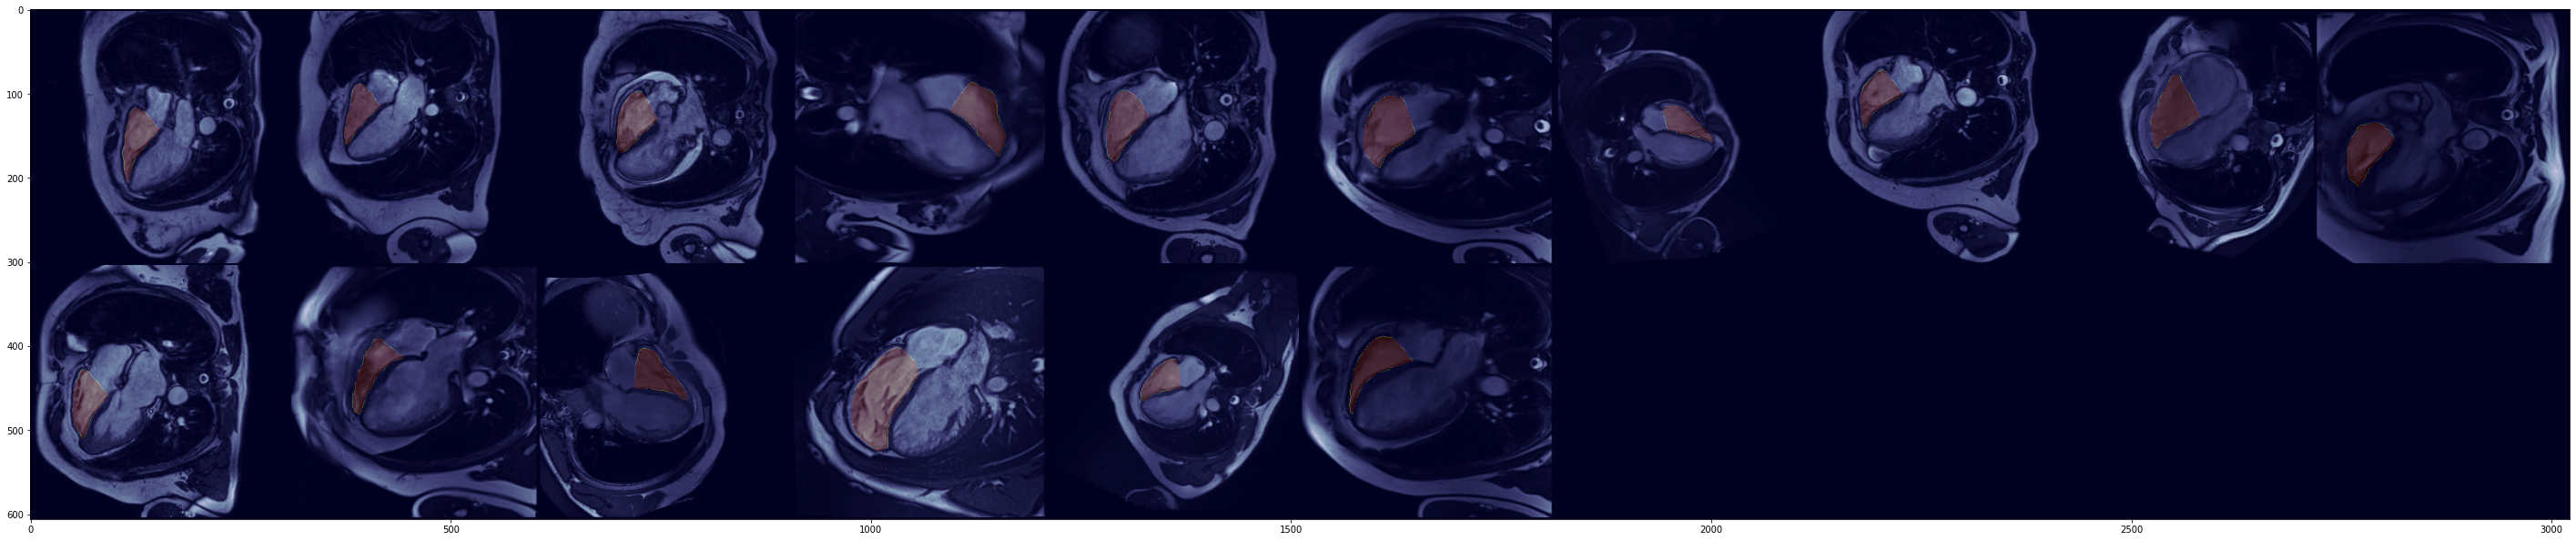

In [17]:
xb1, yb1 = dls.train.one_batch()
xb1.show(figsize = (50, 50))
yb1.show(add_to_existing=True, alpha=0.25, cmap='jet')

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.9120108485221863)

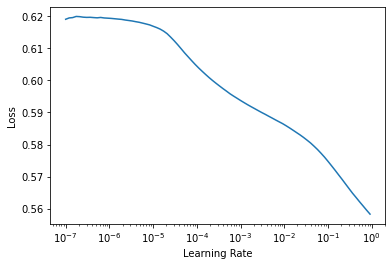

In [21]:
learn.lr_find()

In [21]:
learn.fine_tune(20)

Better model found at epoch 0 with dice value: 0.1170627172486282.


Better model found at epoch 0 with dice value: 0.31578722409417276.
Better model found at epoch 1 with dice value: 0.4698712383430727.
Better model found at epoch 2 with dice value: 0.5524825479339551.
Better model found at epoch 3 with dice value: 0.5993983661107047.


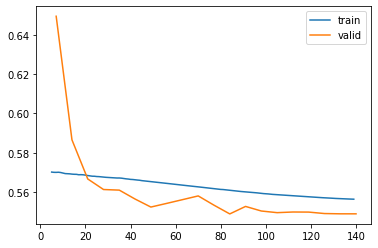

In [22]:
learn.recorder.plot_loss()

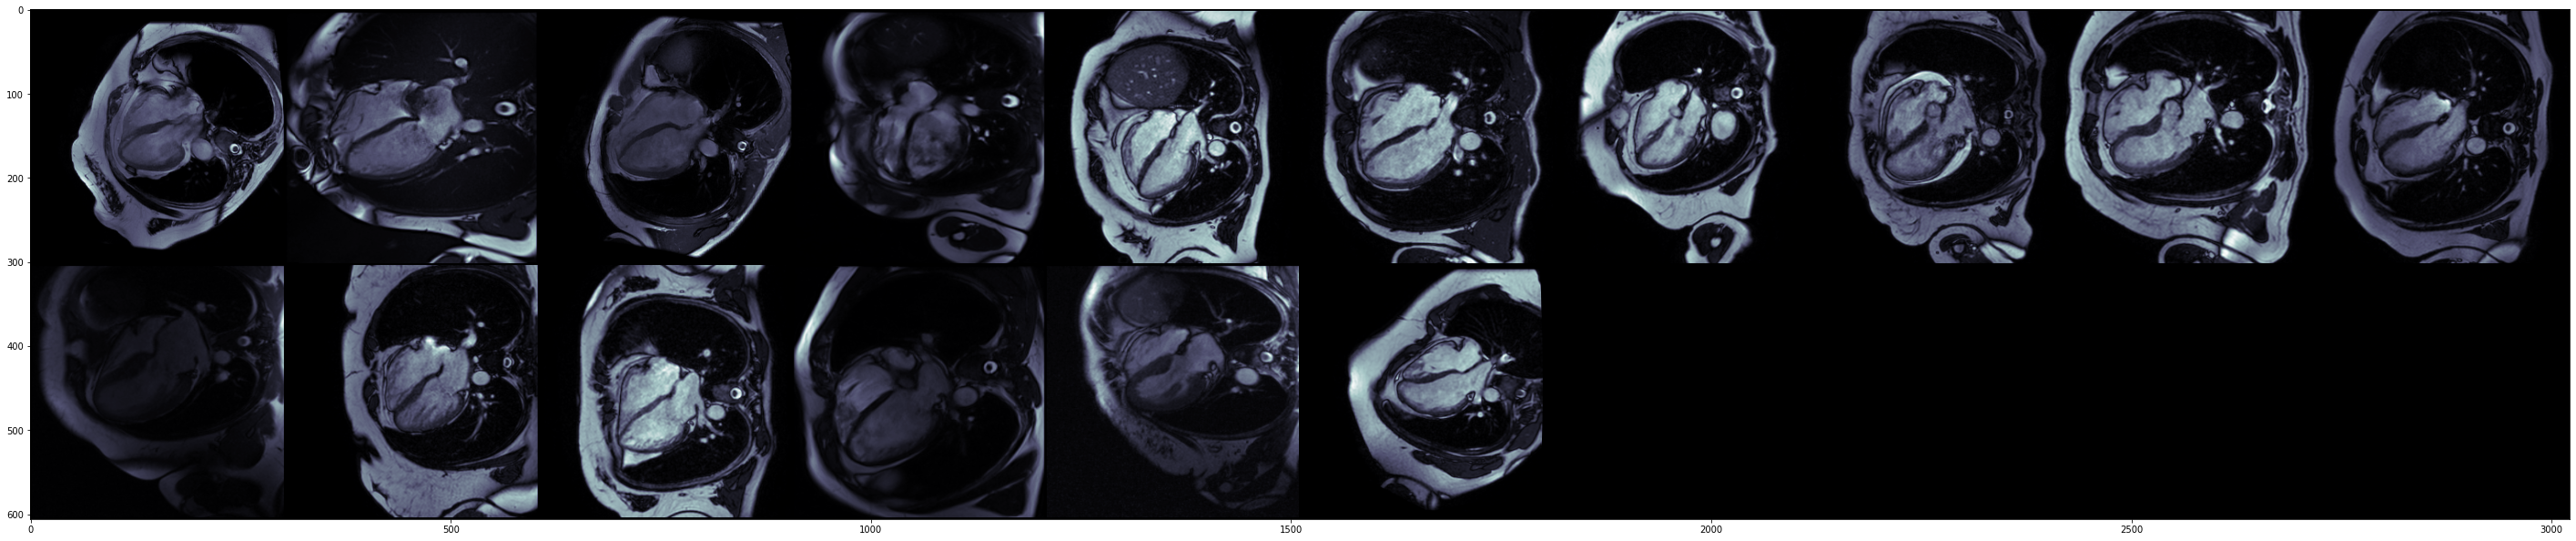

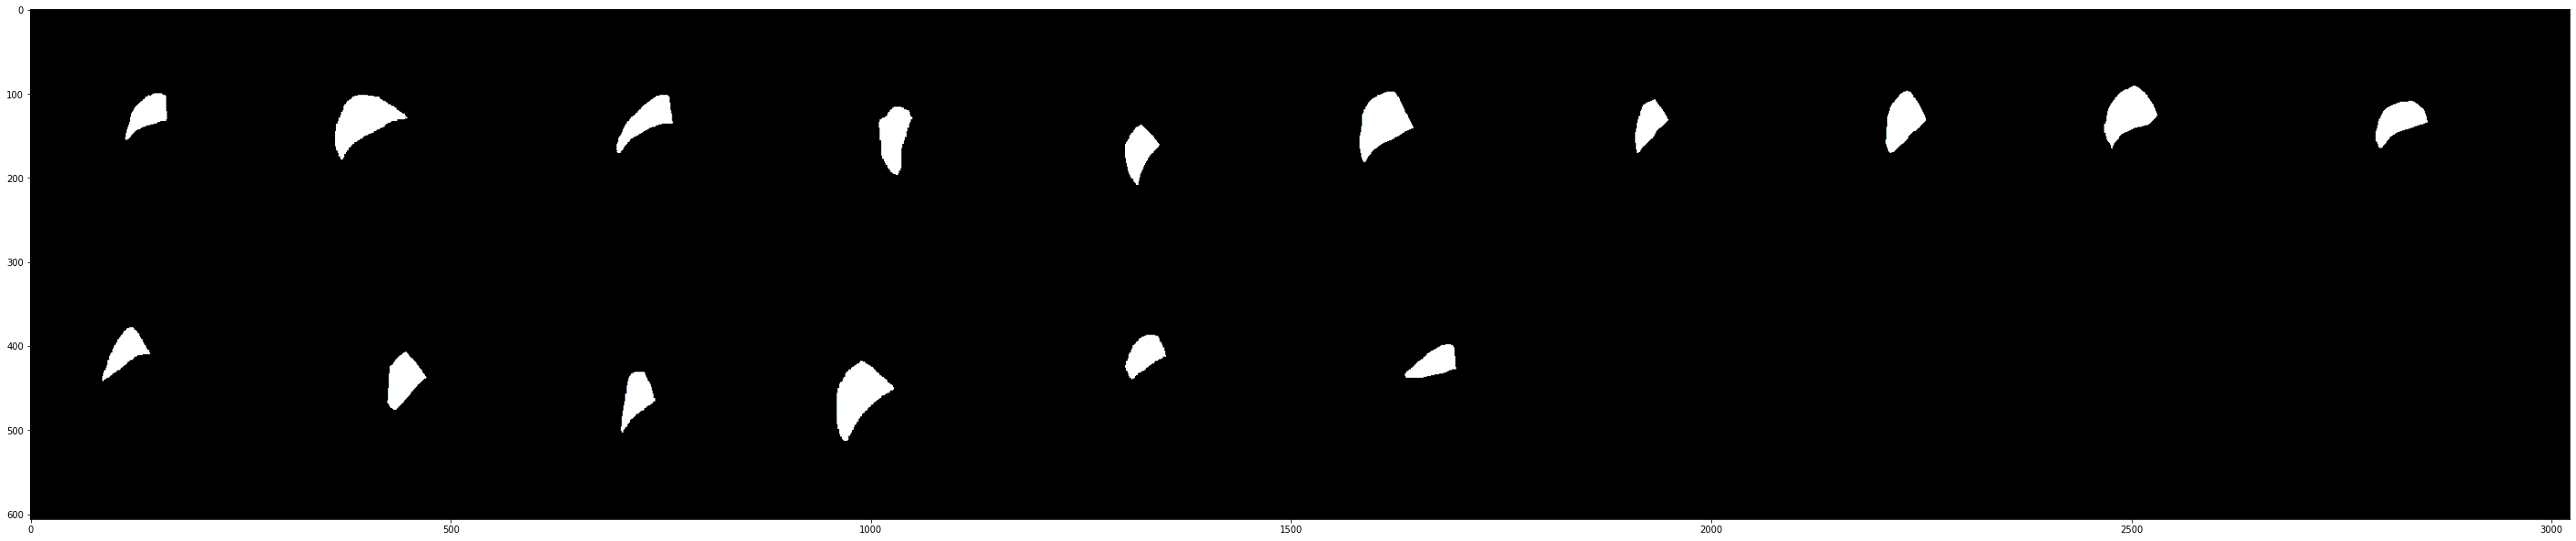

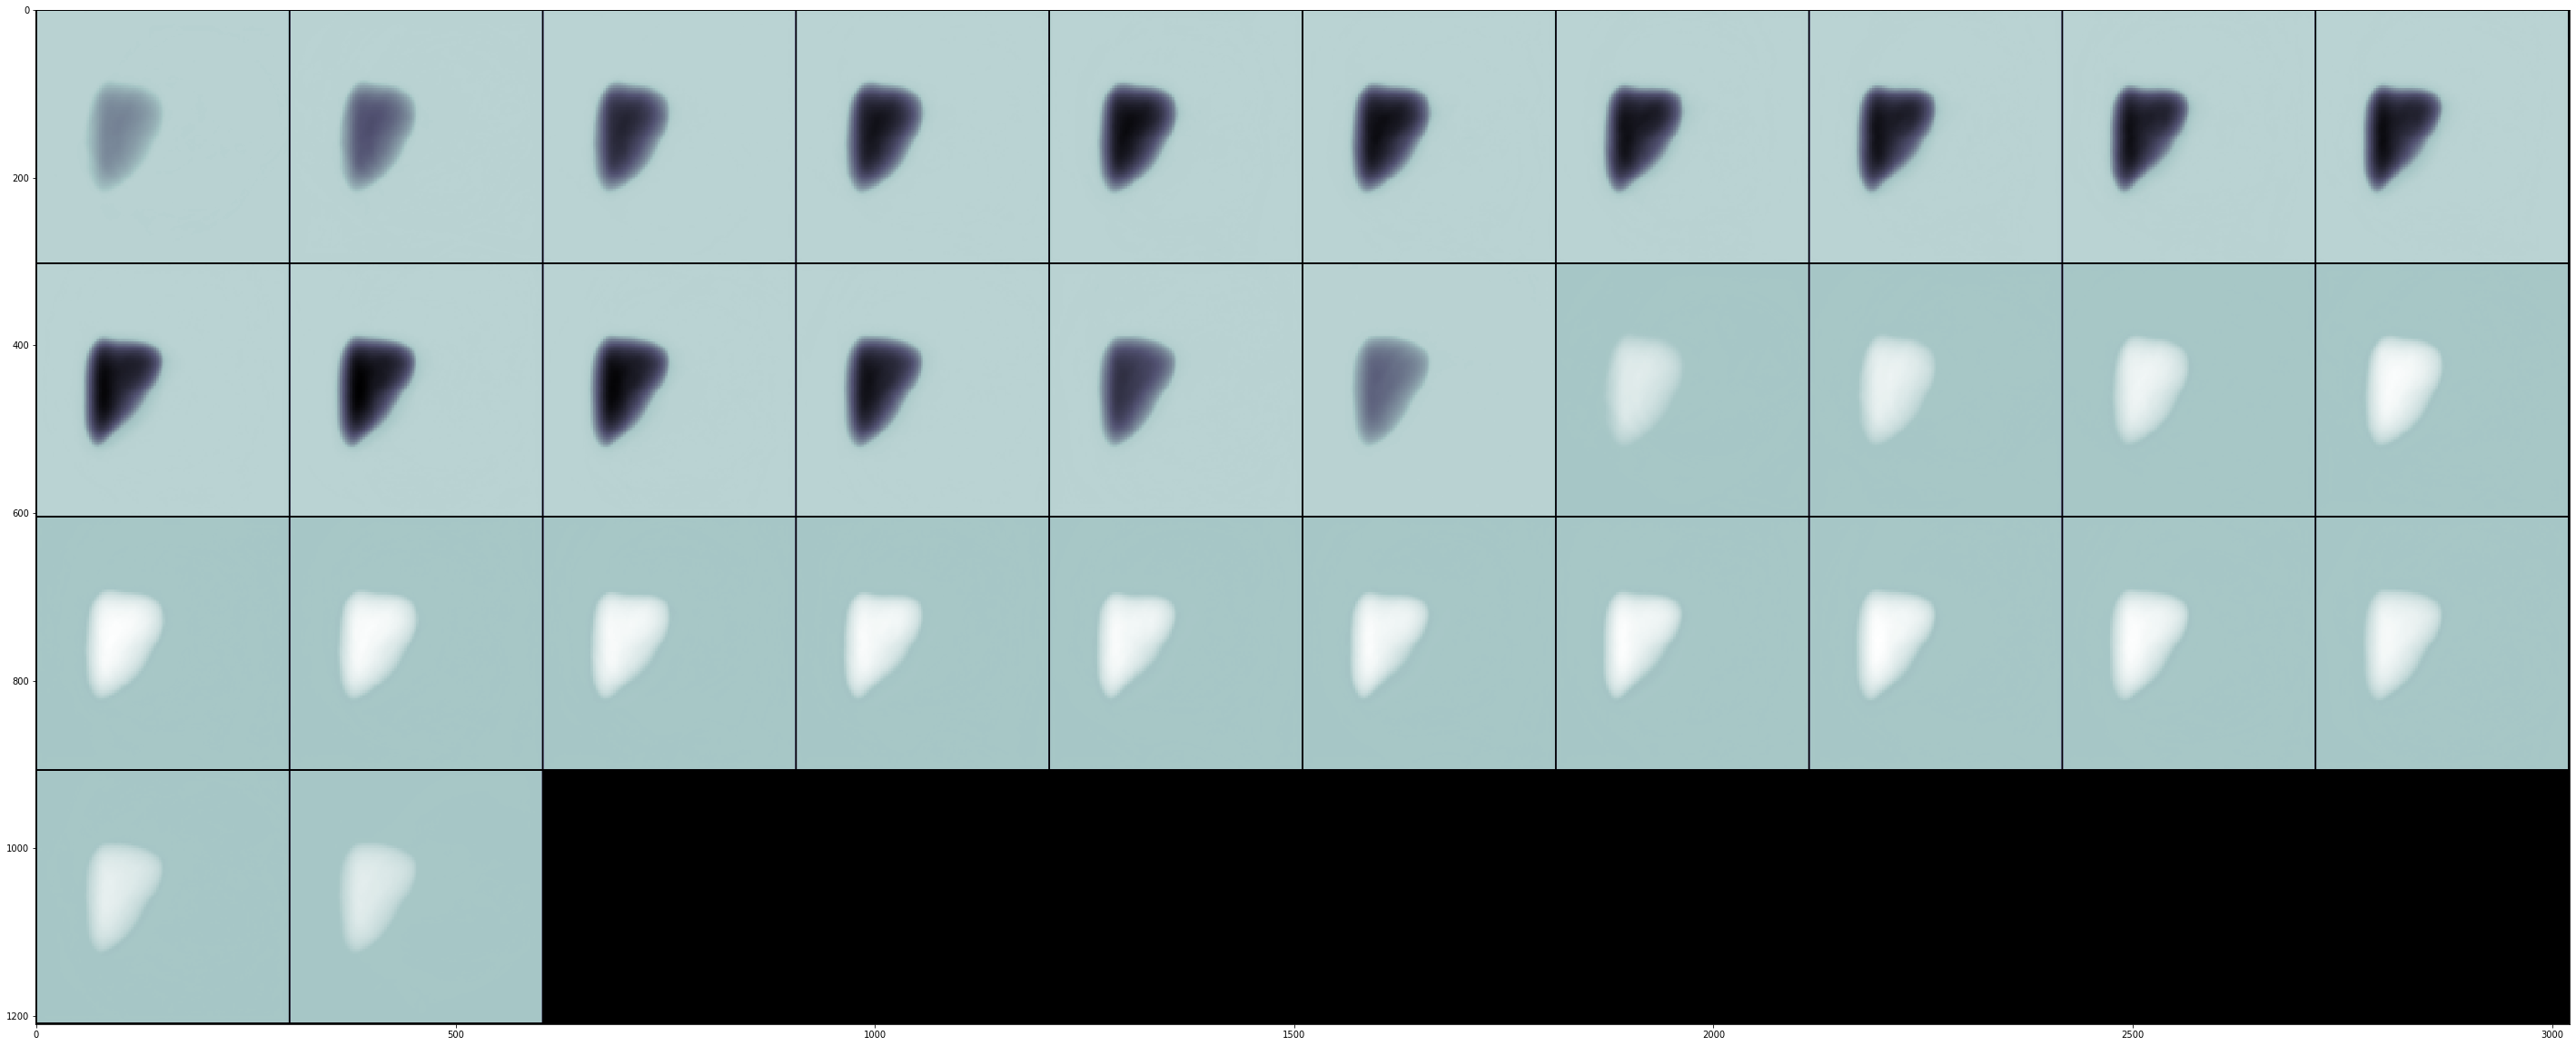

In [24]:
learn.show_results(ds_idx=1, nrows=5, figsize=(50,50))

In [25]:
learn.save('UNet3d-RV-LA-ED')

Path('/host_dir/home/adrian/extras/RV/MnM-2_processed/models_LA_ED/UNet3d-RV-LA-ED.pth')

+ **Looks great after first try**

# Inference

In [32]:
df_test=df[df.set=='test']

In [19]:
dls=dataloader_creator(fn_col=0,label_col=1,number_studies=1,size=300,bs=16)
learn = unet_learner_3d(dls, resnet34_3d, n_out=2,                       
                        metrics = [Dice],
                        model_dir = './models_LA_ED',
                        cbs = [SaveModelCallback(monitor='dice')]
                       )

learn.to_fp16()

In [19]:
learn = learn.load('/host_dir/home/adrian/extras/RV/MnM-2_processed/models_LA_ED/UNet3d-RV-LA-ED')

In [20]:
image_path=path/df_test.LA_ED.iloc[0].replace('test','training').replace('192','001')
mask_path=path/'training/001/001_LA_ED_gt.nii.gz'

In [21]:
image_path=path/df.LA_ED.iloc[2]
mask_path=path/df.LA_ED_gt.iloc[2]

In [22]:
image_nii = nib.load(image_path)
image_nii.shape

(320, 320, 1)

In [23]:
image_path

Path('/host_dir/home/adrian/extras/RV/MnM-2_processed/training/019/019_LA_ED.nii.gz')

In [24]:
mask_path

Path('/host_dir/home/adrian/extras/RV/MnM-2_processed/training/019/019_LA_ED_gt.nii.gz')

In [25]:
mask_nii = nib.load(mask_path)
mask_nii.shape

(320, 320, 1)

In [26]:
np.round(image_nii.affine)
np.round(mask_nii.affine)

array([[   0.,    1.,   -0., -154.],
       [   1.,   -0.,    0., -189.],
       [   0.,   -0.,   -1.,  -29.],
       [   0.,    0.,    0.,    1.]])

In [ ]:
plt.figure(figsize=(50,50))
plt.subplot(1,2,1)
plt.imshow(image_nii.dataobj[:,:,0], 'gray', interpolation='none')
plt.subplot(1,2,2)
plt.imshow(image_nii.dataobj[:,:,0], 'gray', interpolation='none')
plt.imshow(mask_nii.dataobj[:,:,0], 'jet', interpolation='none', alpha=0.5)
plt.show()

In [ ]:
for i in range(0,len(df_test)):
    image_path=path/df_test.LA_ED.iloc[i].replace('test','validation')
    image_nii = nib.load(image_path)
    np.round(image_nii.affine)    
    mask_predicted=learn.predict(image_nii.dataobj[:,:])
    final_mask=np.uint8(mask_predicted[0].detach().cpu().argmax(0))
    plt.figure(figsize=(50,50))
    plt.subplot(1,2,1)
    plt.imshow(image_nii.dataobj[:,:,0], 'gray', interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(image_nii.dataobj[:,:,0], 'gray', interpolation='none')
    plt.imshow(final_mask[0], 'jet', interpolation='none', alpha=0.5)
    plt.show()

In [30]:
dl = dls.test_dl([image_nii.dataobj[:,:]], rm_type_tfms=None, num_workers=0)
preds = learn.get_preds(dl=dl, with_input=True, with_decoded=True,act=torch.sigmoid)